In [1]:
import torch
import torchvision
import os
import cv2
import numpy as np
from torch import nn
from glob import glob
import timm
import torch.nn.functional as F

In [2]:
image_paths = './Data/*/*'
image_paths = glob(image_paths)

In [3]:
image_paths

['./Data/Glaucoma/images-30.jpeg',
 './Data/Glaucoma/image-3.jpeg',
 './Data/Glaucoma/images-71.jpeg',
 './Data/Glaucoma/images-26.jpeg',
 './Data/Glaucoma/images-3.jpeg',
 './Data/Glaucoma/images-51.jpeg',
 './Data/Glaucoma/images-10.jpeg',
 './Data/Glaucoma/images-47.jpeg',
 './Data/Glaucoma/images-46.jpeg',
 './Data/Glaucoma/images-11.jpeg',
 './Data/Glaucoma/images-50.jpeg',
 './Data/Glaucoma/images.jpeg',
 './Data/Glaucoma/images-2.jpeg',
 './Data/Glaucoma/images-27.jpeg',
 './Data/Glaucoma/images-70.jpeg',
 './Data/Glaucoma/image-2.jpeg',
 './Data/Glaucoma/images-66.jpeg',
 './Data/Glaucoma/images-31.jpeg',
 './Data/Glaucoma/image-9.jpeg',
 './Data/Glaucoma/images-5.jpeg',
 './Data/Glaucoma/image-12.jpeg',
 './Data/Glaucoma/images-57.jpeg',
 './Data/Glaucoma/images-16.jpeg',
 './Data/Glaucoma/images-41.jpeg',
 './Data/Glaucoma/images-36.jpeg',
 './Data/Glaucoma/image-5.jpeg',
 './Data/Glaucoma/images-9.jpeg',
 './Data/Glaucoma/images-25.png',
 './Data/Glaucoma/images-20.jpeg',
 '

In [4]:
labels = []
images = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[2]
    image = image_path.split(os.path.sep)[3]
    labels.append(label)
    images.append(image)

In [5]:
labels = np.array(labels, dtype='str')
label2pred = dict(zip(np.unique(labels), range(0, 4)))
pred2label = dict(zip(range(0, 4), np.unique(labels)))
n_classes = len(np.unique(labels))

In [6]:
class IrisDisease(torch.utils.data.Dataset):
    
    def __init__(self, image_paths, labels, transforms=None):
        super(IrisDisease, self).__init__()
        
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
            
        label = self.labels[idx]
        label = label2pred[label]
        label = torch.tensor(label)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, label        

In [7]:
device='mps'

In [8]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=42)

In [9]:
tr_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(1.0),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.RandomRotation(60),
    torchvision.transforms.RandomVerticalFlip(1.0),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
train_dataset = IrisDisease(image_paths=train_image_paths, labels=train_labels, transforms=tr_transforms)
test_dataset = IrisDisease(image_paths=test_image_paths, labels=test_labels, transforms=val_transforms)
# train_dataset = Dataset(image_paths=image_paths, label=labels, transforms=torchvision.transforms.ToTensor())

In [11]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cataracts


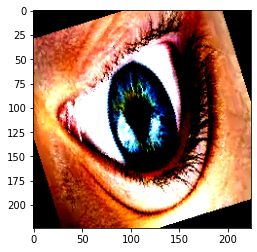

In [12]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[10][0].permute(1, 2, 0))
print(pred2label[train_dataset[10][1].item()])

In [13]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)          
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [14]:
class EfficientNetB0(ClassificationBase):
    
    def __init__(self):
        super().__init__()
        
        self.network = timm.create_model('efficientnet_b0', pretrained=True)
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, n_classes)
        
        
    def forward(self, batch):
        batch = batch.to(device)
        return torch.sigmoid(self.network(batch))
        
        
        
model = EfficientNetB0()     

In [15]:
def fit(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), 3e-4)
    for epoch in range(epochs):
        lrs = []
        loss = 0
        acc = 0
        for batch in tqdm.tqdm(train_loader):
            loss, acc = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, loss, acc))
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
model = model.to('mps')

In [17]:
evaluate(model, test_dataloader)

{'val_loss': 1.3951598405838013, 'val_acc': 0.23529411852359772}

In [39]:
import tqdm
history = fit(100'.'l
              '.?"L."'', model, train_dataloader, test_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.11s/it]


Epoch [0], loss: 0.9773, acc: 0.8780
Epoch [0], val_loss: 1.0420, val_acc: 0.7059


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.29s/it]


Epoch [1], loss: 0.9511, acc: 0.8293
Epoch [1], val_loss: 0.9999, val_acc: 0.7059


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.37s/it]


Epoch [2], loss: 0.8754, acc: 0.9268
Epoch [2], val_loss: 0.9804, val_acc: 0.7353


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.69s/it]


Epoch [3], loss: 0.9005, acc: 0.8537
Epoch [3], val_loss: 0.9841, val_acc: 0.7353


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.46s/it]


Epoch [4], loss: 0.8421, acc: 0.9512
Epoch [4], val_loss: 0.9828, val_acc: 0.7353


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  7.00s/it]


Epoch [5], loss: 0.7786, acc: 1.0000
Epoch [5], val_loss: 0.9802, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.94s/it]


Epoch [6], loss: 0.7879, acc: 0.9756
Epoch [6], val_loss: 0.9818, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.45s/it]


Epoch [7], loss: 0.7593, acc: 1.0000
Epoch [7], val_loss: 0.9753, val_acc: 0.7941


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.80s/it]


Epoch [8], loss: 0.7554, acc: 1.0000
Epoch [8], val_loss: 0.9767, val_acc: 0.7941


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.39s/it]


Epoch [9], loss: 0.7544, acc: 1.0000
Epoch [9], val_loss: 0.9783, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.60s/it]


Epoch [10], loss: 0.7519, acc: 1.0000
Epoch [10], val_loss: 0.9739, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.25s/it]


Epoch [11], loss: 0.7466, acc: 1.0000
Epoch [11], val_loss: 0.9703, val_acc: 0.7353


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.23s/it]


Epoch [12], loss: 0.7477, acc: 1.0000
Epoch [12], val_loss: 0.9798, val_acc: 0.7353


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.96s/it]


Epoch [13], loss: 0.7480, acc: 1.0000
Epoch [13], val_loss: 0.9924, val_acc: 0.7059


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.54s/it]


Epoch [14], loss: 0.7576, acc: 0.9756
Epoch [14], val_loss: 0.9925, val_acc: 0.7059


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.59s/it]


Epoch [15], loss: 0.7485, acc: 1.0000
Epoch [15], val_loss: 0.9668, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.21s/it]


Epoch [16], loss: 0.7468, acc: 1.0000
Epoch [16], val_loss: 0.9763, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.09s/it]


Epoch [17], loss: 0.7605, acc: 1.0000
Epoch [17], val_loss: 0.9808, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch [18], loss: 0.7528, acc: 1.0000
Epoch [18], val_loss: 0.9903, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.79s/it]


Epoch [19], loss: 0.7454, acc: 1.0000
Epoch [19], val_loss: 0.9843, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.15s/it]


Epoch [20], loss: 0.7504, acc: 1.0000
Epoch [20], val_loss: 0.9845, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.14s/it]


Epoch [21], loss: 0.7456, acc: 1.0000
Epoch [21], val_loss: 0.9783, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  7.00s/it]


Epoch [22], loss: 0.7463, acc: 1.0000
Epoch [22], val_loss: 0.9797, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.47s/it]


Epoch [23], loss: 0.7532, acc: 1.0000
Epoch [23], val_loss: 0.9835, val_acc: 0.7647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.99s/it]


Epoch [24], loss: 0.7523, acc: 1.0000
Epoch [24], val_loss: 1.0098, val_acc: 0.7353


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.23s/it]


Epoch [25], loss: 0.7452, acc: 1.0000
Epoch [25], val_loss: 1.0139, val_acc: 0.7353


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.98s/it]


Epoch [26], loss: 0.7444, acc: 1.0000
Epoch [26], val_loss: 1.0110, val_acc: 0.7353


 20%|██████████████████                                                                        | 1/5 [00:09<00:39,  9.76s/it]


KeyboardInterrupt: 

In [143]:
torch.save(model.state_dict(), './model_trained.pth')

In [120]:
# model = torch.load('./secondary_model.pth')

In [20]:
model_1 = model.load_state_dict(torch.load('./secondary_model.pth'))
model_1

<All keys matched successfully>

In [146]:
model__1.load_state_dict(torch.load('./secondary_model.pth'))

<All keys matched successfully>

In [22]:
evaluate(model,test_dataloader)

{'val_loss': 1.1182469129562378, 'val_acc': 0.7058823704719543}

In [261]:
import cv2
import torch
import torchvision
import cv2
import numpy as np
from torch import nn
import timm
import torch.nn.functional as F

def getModel():
    label2pred = {'Cataracts': 0, 'Glaucoma': 1, 'Healthy': 2, 'Uveitis': 3}
    n_classes = 4
    class IrisDisease(torch.utils.data.Dataset):
        def __init__(self, image_paths, labels, transforms=None):
            super(IrisDisease, self).__init__()
            self.image_paths = image_paths
            self.labels = labels
            self.transforms = transforms
        def __len__(self):
            return len(self.image_paths)
        def __getitem__(self, idx):
            image = cv2.imread(self.image_paths[idx])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            label = self.labels[idx]
            label = label2pred[label]
            label = torch.tensor(label)
            if self.transforms:
                image = self.transforms(image)
            return image, label        
    device='mps'
    tr_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.RandomHorizontalFlip(1.0),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.RandomRotation(60),
        torchvision.transforms.RandomVerticalFlip(1.0),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        torchvision.transforms.Resize((224,224))
    ])
    class ClassificationBase(nn.Module):
        def training_step(self, batch):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            out = self(images)
            loss = F.cross_entropy(out, labels)
            acc = accuracy(out, labels)          
            return loss, acc
        def validation_step(self, batch):
            images, labels = batch 
            images = images.to(device)
            labels = labels.to(device)
            out = self(images)                    
            loss = F.cross_entropy(out, labels)  
            acc = accuracy(out, labels)          
            return {'val_loss': loss.detach(), 'val_acc': acc}
        def validation_epoch_end(self, outputs):
            batch_losses = [x['val_loss'] for x in outputs]
            epoch_loss = torch.stack(batch_losses).mean()   
            batch_accs = [x['val_acc'] for x in outputs]
            epoch_acc = torch.stack(batch_accs).mean()    
            return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}        
        def epoch_end(self, epoch, result):
            print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    def evaluate(model, val_loader):
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)
    class EfficientNetB0(ClassificationBase):
        def __init__(self):
            super().__init__()
            self.network = timm.create_model('efficientnet_b0', pretrained=True)
            num_ftrs = self.network.classifier.in_features
            self.network.classifier = nn.Linear(num_ftrs, n_classes)
        def forward(self, batch):
            batch = batch.to(device)
            return torch.sigmoid(self.network(batch))
    model = EfficientNetB0()
    model = model.to('mps')
    model.load_state_dict(torch.load('/Users/deveshkedia/Desktop/Projects/Doing/DiseaseDetection/Models/model_trained.pth'))
    return model
val_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        torchvision.transforms.Resize((224,224))
    ])


In [262]:
model = getModel()

In [51]:
val_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        torchvision.transforms.Resize((224,224))
    ])

image = cv2.imread('./Data/Healthy/0.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = val_transforms(image)
image = image.to('mps')
image = torch.reshape(image,(1,3,224,224))
pred = model(image).detach()
pred = pred.cpu()
pred = np.argmax(pred).item()
pred = pred2label[pred]


In [52]:
pred

'Healthy'

In [46]:
pred2label

{0: 'Cataracts', 1: 'Glaucoma', 2: 'Healthy', 3: 'Uveitis'}

In [41]:
model.eval()

EfficientNetB0(
  (network): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size